# BLAES Units Behavior Analyses

This notebook contains code for analyzing behavioral performance and change in memory (d') score across conditions.

---

> *Contact: Justin Campbell (justin.campbell@hsc.utah.edu)*  
> *Version: 10/19/2024*

## 1. Import Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from scipy.stats import ttest_ind, ttest_rel, fisher_exact
import seaborn as sns

from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %config InlineBackend.figure_format='svg'

In [2]:
export = True

## 2. Load Data

In [3]:
# Define directories
proj_dir = '/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits'
results_dir = os.path.join(proj_dir, 'Results')
trialinfo_dir = os.path.join(proj_dir, 'TrialInfo')

# Stim Info
stim_info = pd.read_csv(os.path.join(proj_dir, 'BLAESUnits Stim.csv'))
stim_info = stim_info[stim_info['Included'] == 1]

# Load StudyOutcomes.csv files
outcome_dfs = []
outcome_files = glob.glob(os.path.join(trialinfo_dir, '*TrialInfo.csv'), recursive=True)
for file in outcome_files:
    df = pd.read_csv(file, index_col=0)
    df['Imageset'] = file.split('/')[-1].split('_')[0]
    outcome_dfs.append(df)
outcome_dfs = pd.concat(outcome_dfs).reset_index()

# Only retain imagesets within outcome_dfs thare are marked as Included pIDs in stim_info
outcome_dfs = outcome_dfs[outcome_dfs['Imageset'].isin(stim_info[stim_info['Included'] == 1]['pID'])]

# Get Hit/Miss rates
rates_df = outcome_dfs.groupby(['Condition', 'Imageset'])['Outcome'].value_counts(normalize=True).unstack()
rates_df.columns.name = None
rates_df = rates_df.reset_index()
rates_df = rates_df.melt(id_vars=['Condition', 'Imageset'], value_name='Rate', var_name='Type')
hit_rates = rates_df[rates_df['Type'] == 'Hit']
hit_rates.loc[:,'Rate'] = hit_rates['Rate'] * 100

In [4]:
exp_info = pd.read_csv(os.path.join(proj_dir, 'BLAESUnits Stim.csv'), index_col=0)
exp_info = exp_info[exp_info['Included'] == 1]
fa_rates = exp_info['FA'].values * 100
d_primes = np.asarray([exp_info["NoStim d'"].values, exp_info["Stim d'"].values]).flatten()
d_prime_df = pd.DataFrame({'pID': np.repeat(exp_info.index, 2), 'Condition': ['No-Stim', 'Stim']*len(exp_info), 'd_prime': d_primes})
d_prime_diffs = d_prime_df[d_prime_df['Condition'] == 'Stim']['d_prime'].values - d_prime_df[d_prime_df['Condition'] == 'No-Stim']['d_prime'].values

## 3. Summarize Behavioral Performance ($d'$)

In [5]:
# create dataframe for model
model_df = pd.merge(d_prime_df, exp_info[['Experiment']], left_on='pID', right_index=True)

# Linear mixed effects model
md = smf.mixedlm("d_prime ~ Condition * Experiment", model_df, groups=model_df['pID'])
mdf = md.fit()
print(mdf.summary())

                            Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              d_prime 
No. Observations:              60                   Method:                          REML    
No. Groups:                    30                   Scale:                           0.3831  
Min. group size:               2                    Log-Likelihood:                  -56.1195
Max. group size:               2                    Converged:                       Yes     
Mean group size:               2.0                                                           
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           1.643    0.234  7.022 0.000  1.184  

/Users/justincampbell/opt/anaconda3/envs/mne/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/justincampbell/opt/anaconda3/envs/mne/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [6]:
validPal = ['#da1b61', '#e6e6e6']
pairPal = ['#ffb84d', '#5e4b8b']

<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mq/6f6ky9r97r1_mqfg3vjq9fd00000gn/T/ipykernel_23978/1980476868.py:29: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel("$\Delta d'$", fontsize = 'large', labelpad = -5)


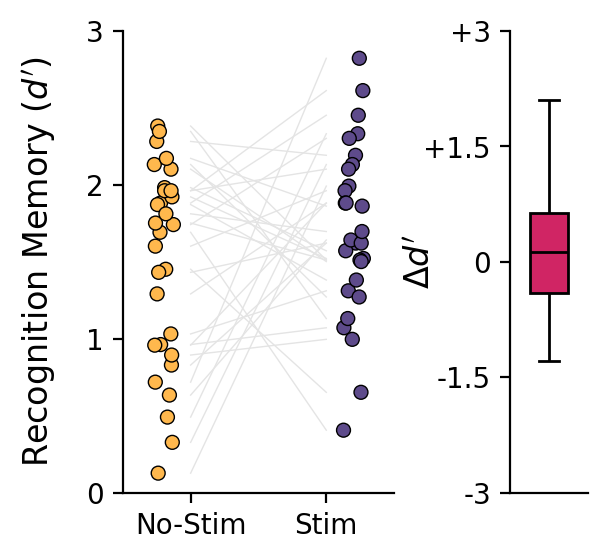

In [7]:
# plotPal = ['#e6e6e6', sns.color_palette('flare')[2]]
plotPal = pairPal

fig = plt.figure(figsize=(3, 3))
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
fig.subplots_adjust(wspace = 1.5)

# Plotting
sns.stripplot(data=d_prime_df, x='Condition', y='d_prime', hue='Condition', palette = plotPal, legend = False, size = 5, jitter = 0.15, dodge = True, edgecolor = 'black', linewidth = 0.5, ax = ax1)
for i in range(0, d_prime_df.shape[0], 2):
    ax1.plot(d_prime_df['Condition'].iloc[i:i+2], d_prime_df['d_prime'].iloc[i:i+2], color='#e4e4e4', linewidth=.5)
sns.boxplot(d_prime_diffs, ax = ax2, color = validPal[0], width = 0.5, flierprops = dict(marker = 'o', markersize = 3), linecolor = 'k', saturation = 0.9)
# plt.suptitle('Condition: $z$ = %.2f, $p$ = %.3f' %(mdf.tvalues['Condition[T.Stim]'], mdf.pvalues['Condition[T.Stim]']), fontsize = 'small')

# Figure aesthetics
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
sns.despine(top = True, right = True)
# fig.text(0.5, -.075, 'Condition', ha='center', fontsize = 'large')
ax1.set_xlabel('')
ax1.set_ylabel("Recognition Memory ($d'$)", fontsize = 'large', labelpad = 10)
ax1.set_ylim(0, 3)
ax1.set_yticks(np.arange(0,4,1))
ax1.set_xlim(-.5, 1.5)
ax1.set_xticks([0, 1], ['No-Stim', 'Stim'], fontsize = 'medium')
ax2.set_xticks([])
ax2.set_ylabel("$\Delta d'$", fontsize = 'large', labelpad = -5)
ax2.set_yticks(np.arange(-3, 4.5, 1.5), ['-3', '-1.5', '0', '+1.5', '+3'])

# Export & Display
if export:
    plt.savefig((os.path.join(results_dir, 'Group', 'Figures', 'dPrime.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

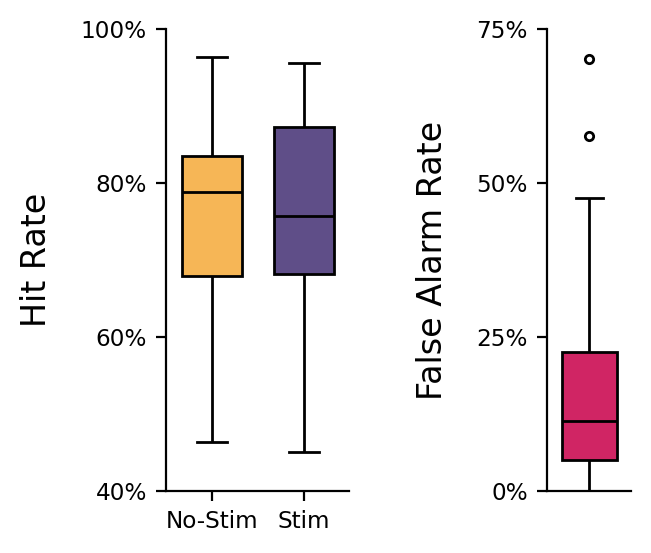

In [8]:
fig = plt.figure(figsize=(3, 3))
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1.5])
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 3])
plotPal = pairPal
fig.subplots_adjust(wspace = 1.125)

# Plotting
sns.boxplot(x='Condition', y='Rate', data=hit_rates, hue = 'Condition', palette = plotPal, width = 0.75, gap = 0.125, linecolor = 'k', saturation = 0.9, ax = ax1, legend = False)
sns.boxplot(fa_rates, width = 0.75, gap = 0.125, linecolor = 'k', saturation = 0.9, ax = ax2, legend = False, color = validPal[0], fliersize=3)

# Paired t-test
t, p = ttest_rel(hit_rates[hit_rates['Condition'] == 0]['Rate'], hit_rates[hit_rates['Condition'] == 1]['Rate'])
dof = len(hit_rates[hit_rates['Condition'] == 0]) - 1

# Figure aesthetics
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
ax1.set_ylabel('Hit Rate', fontsize = 'large', labelpad = 10)
ax2.set_ylabel('False Alarm Rate', fontsize = 'large', labelpad = 10)
ax1.set_yticks(np.arange(40, 101, 20), ['40%', '60%', '80%', '100%'])
ax2.set_yticks(np.arange(0, 100, 25), ['0%', '25%', '50%', '75%'])
ax1.set_xticks([0, 1], ['No-Stim', 'Stim'])
ax2.set_xticks([], [])
ax2.set_ylim(0, 75)
handles = [Rectangle((0, 0), 1, 1, color = plotPal[0]), Rectangle((0, 0), 1, 1, color = plotPal[1])]
for ax in [ax1,ax2]:
    sns.despine(top = True, right = True, ax = ax)
    ax.set_xlabel('')

# Export & Display
if export:
    plt.savefig((os.path.join(results_dir, 'Group', 'Figures', 'HitFARates.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

In [9]:
hit_rates.groupby('Condition')['Rate'].describe()

,count,mean,std,min,25%,50%,75%,max
Condition,,,,,,,,
0,30.0,75.700855,13.500747,46.25,67.8125,78.750,83.4375,96.250000
1,30.0,75.016129,14.274918,45.00,68.1250,75.625,87.1875,95.483871


In [10]:
print('FA Rates: M = %.1f, SD = %.1f' %(fa_rates.mean(), fa_rates.std()))
print('Range: %.1f - %.1f' %(fa_rates.min(), fa_rates.max()))

FA Rates: M = 17.9, SD = 17.4
Range: 0.0 - 70.0


In [11]:
stats_df = pd.read_csv(os.path.join(results_dir, 'Group', 'SpikeStats.csv'), index_col = 0)
stats_df = stats_df[stats_df['Valid'] == 1] # get only valid units

mod_counts = {}
unit_counts = {}
pID_dprimes = {}
pIDs = d_prime_df['pID'].unique()

for pID in exp_info.index:
    pID_df = stats_df[stats_df['pID'] == pID]
    if len(pID_df) == 0:
        mod_counts[pID] = np.nan
    else:
        mod_counts[pID] = len(pID_df[pID_df['StimSig'] == True])
    unit_counts[pID] = len(pID_df)

for i, pID in enumerate(pIDs):
    pID_dprimes[pID] = d_prime_diffs[i]
    
df1 = pd.DataFrame(pID_dprimes, index = ['d_prime']).T.reset_index()
df2 = pd.DataFrame(mod_counts, index = ['Modulated']).T.reset_index()
df3 = pd.DataFrame(unit_counts, index = ['Total']).T.reset_index()

props_df = pd.merge(df1, df2, left_on='index', right_on='index')
props_df = pd.merge(props_df, df3, left_on='index', right_on='index')

# if d_prime is less than -0.2, set Outcome to "Decrease". If d_prime is greater than -0.2, set Outcome to "Increase". Otherwise, set Outcome to "Null" 
# props_df['Outcome'] = np.where(props_df['d_prime'] < -0.2, 'Decrease', np.where(props_df['d_prime'] > 0.2, 'Increase', 'Null'))


# if d_prime is less than -.2 or greater than 0.2 set outcome to "Change" otherwise set outcome to "Null"
props_df['Outcome'] = np.where((props_df['d_prime'] < -0.5) | (props_df['d_prime'] > 0.5), 'Change', 'Null')

In [12]:
# Group props_df by Outcome and contrast modulated vs. unmodulated units
modulated = props_df[props_df['Modulated'] > 0]
unmodulated = props_df[props_df['Modulated'] == 0]

# Perform Fisher's exact test
od_test = fisher_exact([[len(modulated[modulated['Outcome'] == 'Change']), len(modulated[modulated['Outcome'] == 'Null'])], [len(unmodulated[unmodulated['Outcome'] == 'Change']), len(unmodulated[unmodulated['Outcome'] == 'Null'])]])
print('Fisher\'s Exact Test: OR = %.2f, p = %.3f' % (od_test[0], od_test[1]))

Fisher's Exact Test: OR = 1.93, p = 0.667


In [13]:
# Add Outcome column to sig_stats_df
stats_df_outcome = pd.merge(stats_df, props_df[['index', 'Outcome']], left_on='pID', right_on='index')

sig_prop_change = {}
sig_prop_null = {}
for region in stats_df['Region'].unique():
    region_df = stats_df_outcome[stats_df_outcome['Region'] == region]
    region_props = region_df.groupby('Outcome')['StimSig'].sum()
    sig_prop_change[region] = region_props.loc['Change'] * 100 / len(region_df[region_df['Outcome'] == 'Change'])
    sig_prop_null[region] = region_props.loc['Null'] * 100 / len(region_df[region_df['Outcome'] == 'Null'])

sig_prop_change_df = pd.DataFrame(sig_prop_change, index = ['Prop']).T.reset_index()
sig_prop_null_df = pd.DataFrame(sig_prop_null, index = ['Prop']).T.reset_index()
sig_prop_change_df.columns = ['Region', 'Prop']
sig_prop_null_df.columns = ['Region', 'Prop']
sig_prop_change_df['Outcome'] = 'Change'
sig_prop_null_df['Outcome'] = 'Null'
sig_prop_df = pd.concat([sig_prop_change_df, sig_prop_null_df])
sig_prop_df

,Region,Prop,Outcome
0,HIP,35.294118,Change
1,OFC,8.333333,Change
2,AMY,42.307692,Change
3,ACC,25.000000,Change
0,HIP,22.916667,Null
1,OFC,38.888889,Null
2,AMY,25.000000,Null
3,ACC,33.333333,Null


<>:36: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mq/6f6ky9r97r1_mqfg3vjq9fd00000gn/T/ipykernel_23978/2042263820.py:36: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_ylabel("Recognition Memory ($\Delta d'$)", fontsize = 'large', labelpad=10)
/var/folders/mq/6f6ky9r97r1_mqfg3vjq9fd00000gn/T/ipykernel_23978/2042263820.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot([dprime_null, dprime_change], ax = ax2, palette = [plotPal[0], plotPal[1]], saturation = 0.9, edgecolor = 'black', linewidth = 0.5)
/var/folders/mq/6f6ky9r97r1_mqfg3vjq9fd00000gn/T/ipykernel_23978/2042263820.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), fontsize = 'mediu

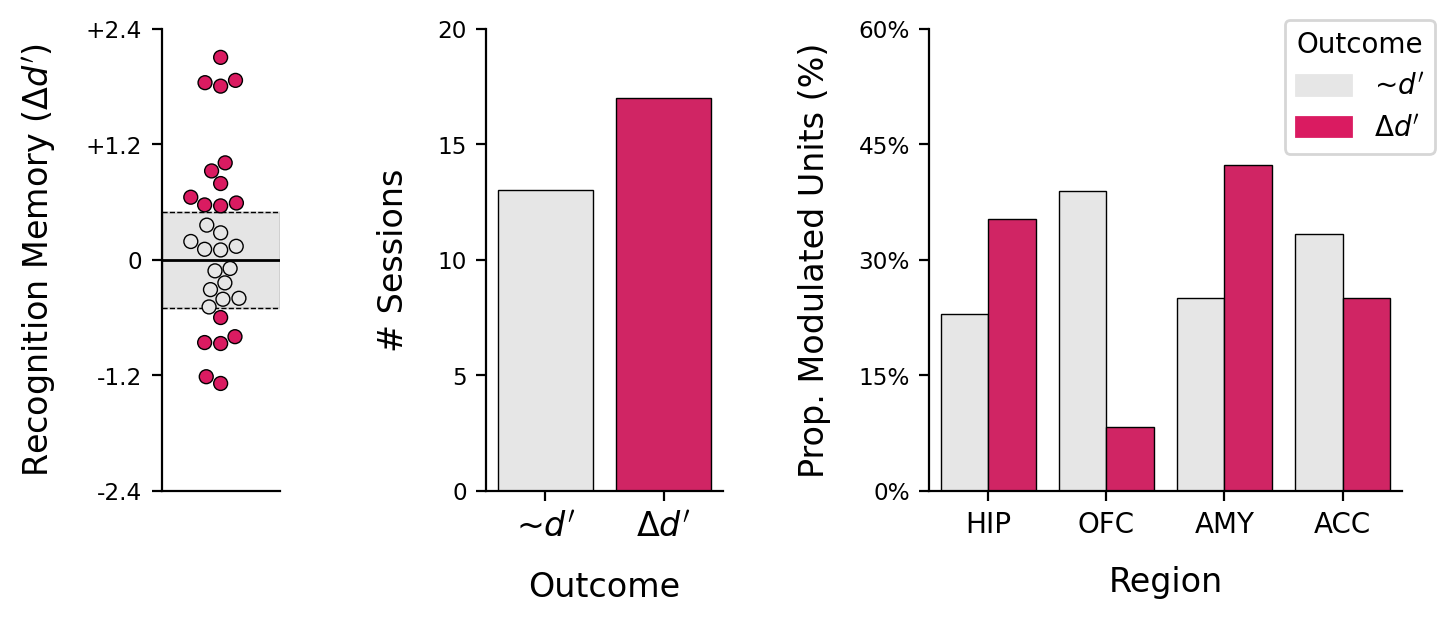

In [14]:
# Figure params
plotPal = ['#e6e6e6', validPal[0]]
fig = plt.figure(figsize=(8, 3))
gs = GridSpec(1, 3, figure=fig, width_ratios=[.75, 1.5, 3])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
fig.subplots_adjust(wspace = 0.75)

# Organize data
point_colors = []
dprime_change = 0
dprime_null = 0
for i in d_prime_diffs:
    if i < -0.5:
        point_colors.append(plotPal[1])
        dprime_change += 1
    elif i > 0.5:
        point_colors.append(plotPal[1])
        dprime_change += 1
    else:
        point_colors.append(plotPal[0])
        dprime_null += 1

# Plotting
sns.swarmplot(d_prime_diffs, ax = ax1, color = point_colors, size = 5, edgecolor = 'black', linewidth = 0.5)
ax1.axhline(0, color='k', linestyle='-', lw = 1)
ax1.axhspan(-.5, .5, color='k', alpha=0.1)
ax1.axhline(-.5, color='k', linestyle='--', lw = .5)
ax1.axhline(.5, color='k', linestyle='--', lw = .5)
sns.barplot([dprime_null, dprime_change], ax = ax2, palette = [plotPal[0], plotPal[1]], saturation = 0.9, edgecolor = 'black', linewidth = 0.5)
sns.barplot(x='Region', y = 'Prop', data=sig_prop_df, ax = ax3, hue = 'Outcome', hue_order = ['Null', 'Change'], palette = [plotPal[0], plotPal[1]], saturation = 0.9, edgecolor = 'black', linewidth = 0.5)

# Figure aesthetics
sns.despine(top = True, right = True)
ax1.set_ylabel("Recognition Memory ($\Delta d'$)", fontsize = 'large', labelpad=10)
ax1.set_yticks(np.arange(-2.4, 3.6, 1.2))
ax1.set_yticklabels(['-2.4', '-1.2', '0', '+1.2', '+2.4'])
ax1.set_ylim(-2.4, 2.4)
ax1.set_xticks([])
ax2.set_ylabel('# Sessions', fontsize = 'large', labelpad=10)
ax2.set_ylim(0, 20)
ax2.set_yticks(np.arange(0, 25, 5))
ax2.set_xticks([0, 1], ["~$d'$", r"$\Delta$$d'$"], fontsize = 'large')
ax2.set_xlabel("Outcome", fontsize = 'large', labelpad = 10)
ax3.set_ylabel('Prop. Modulated Units (%)', fontsize = 'large', labelpad = 10)
ax3.set_yticks(np.arange(0, 75, 15), ['0%', '15%', '30%', '45%', '60%'], fontsize = 'small')
# ax3.set_ylim(0, 100)
ax3.set_xticklabels(ax3.get_xticklabels(), fontsize = 'medium')
ax3.set_xlabel('Region', fontsize = 'large', labelpad = 10)
handles = [Rectangle((0, 0), 1, 1, color = plotPal[0]), Rectangle((0, 0), 1, 1, color = plotPal[1])]
plt.legend(title = 'Outcome', handles = handles, labels = ["~$d'$", r"$\Delta$$d'$"], title_fontsize = 'medium', fontsize = 'medium', bbox_to_anchor = (1.1, 1.05))

# Export & Display
if export:
    plt.savefig((os.path.join(results_dir, 'Group', 'Figures', 'AMMESummary.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

In [15]:
print("Proportion w/ Increased d': %.2f%%" %((props_df['d_prime'] > 0.5).mean() * 100))
print("Proportion w/ Decreased d': %.2f%%" %((props_df['d_prime'] < -0.5).mean() * 100))
print("Proportion w/ Null d': %.2f%%" %(((props_df['d_prime'] >= -0.5) & (props_df['d_prime'] <= 0.5)).mean() * 100))

Proportion w/ Increased d': 36.67%
Proportion w/ Decreased d': 20.00%
Proportion w/ Null d': 43.33%


In [16]:
# Use fisher exact test to compare the number of modulated units per region, split by outcome and StimSig
for region in stats_df_outcome['Region'].unique():
    region_df = stats_df_outcome[stats_df_outcome['Region'] == region]
    region_props = region_df.groupby('Outcome')['StimSig'].sum()
    sig_change_count = region_props.loc['Change']
    sig_null_count = region_props.loc['Null']
    notsig_change_count = len(region_df[region_df['Outcome'] == 'Change']) - sig_change_count
    notsig_null_count = len(region_df[region_df['Outcome'] == 'Null']) - sig_null_count
    fisher_table = [[sig_change_count, notsig_change_count], [sig_null_count, notsig_null_count]]
    odds, p = fisher_exact(fisher_table, alternative='two-sided')
    print('%s: Odds Ratio: %.2f, p = %.3f' %(region, odds, p))
    print('Observed Counts: %s \n' %fisher_table)


HIP: Odds Ratio: 1.83, p = 0.318
Observed Counts: [[np.int64(12), np.int64(22)], [np.int64(11), np.int64(37)]] 

OFC: Odds Ratio: 0.14, p = 0.099
Observed Counts: [[np.int64(1), np.int64(11)], [np.int64(7), np.int64(11)]] 

AMY: Odds Ratio: 2.20, p = 0.632
Observed Counts: [[np.int64(11), np.int64(15)], [np.int64(1), np.int64(3)]] 

ACC: Odds Ratio: 0.67, p = 1.000
Observed Counts: [[np.int64(2), np.int64(6)], [np.int64(2), np.int64(4)]] 

